In [2]:
!pip install textblob

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mysql-connector-python 8.0.13 requires protobuf>=3.0.0, which is not installed.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:
#Basic Libraries

import pandas as pd

import numpy as np

#Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Text Mining
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk

#Warnings
import warnings

#Topic Modelling
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaMulticore
import gensim

#Metrics
from sklearn.metrics import accuracy_score

#Others
from datetime import datetime

C:\Users\lenovo\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
#Reading Files

fb_micro = pd.read_csv('Facebook_Microsoft.csv')
gp_micro = pd.read_csv('GooglePlus_Microsoft.csv')
li_micro = pd.read_csv('LinkedIn_Microsoft.csv')

fb_pal = pd.read_csv('Facebook_Palestine.csv')
gp_pal = pd.read_csv('GooglePlus_Palestine.csv')
li_pal = pd.read_csv('LinkedIn_Palestine.csv')

final = pd.read_csv('News_Final.csv')

### Removing Palestine and Microsoft

In [5]:
# Cleaning data based on the topics required
temp1 = np.where((final['Topic']=='obama'))[0]   #index of Palestine
temp2 = np.where(final['Topic']=='economy')[0]     #index of microsoft
print(len(temp1)+len(temp2))
final.shape #initial shape  -- final dataframe

62538


(93239, 11)

In [6]:
final.drop(temp1,axis=0,inplace=True)   #Dropping Palestine
final.drop(temp2,axis=0,inplace=True)   #Dropping Microsoft
final.shape #final shape  -- final dataframe

(30701, 11)

In [7]:
final.dtypes

IDLink               float64
Title                 object
Headline              object
Source                object
Topic                 object
PublishDate           object
SentimentTitle       float64
SentimentHeadline    float64
Facebook               int64
GooglePlus             int64
LinkedIn               int64
dtype: object

In [8]:
final.head(1)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
5,27790.0,Intellitec Solutions to Host 13th Annual Sprin...,Over 100 attendees expected to see latest vers...,PRWeb,microsoft,2015-03-01 00:19:00,-0.075378,0.036773,-1,-1,-1


In [9]:
#sorting the data according to the publish date
final=final.sort_values(by='PublishDate')
final.head(1)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
5,27790.0,Intellitec Solutions to Host 13th Annual Sprin...,Over 100 attendees expected to see latest vers...,PRWeb,microsoft,2015-03-01 00:19:00,-0.075378,0.036773,-1,-1,-1


In [10]:
final['PublishDate']=pd.to_datetime(final['PublishDate'])    #converting the data type from category to date format

### Removing records that never entered Social Media

In [11]:
temp1 = set(np.where(final['Facebook']==-1)[0])   #index of Facebook = -1
temp2 = set(np.where(final['LinkedIn']==-1)[0])     #index of LinkedIn = -1
temp3 = set(np.where(final['GooglePlus']==-1)[0])   #index of GooglePlus = -1

In [12]:
#Replacing the -1 values with nan
final.Facebook.replace(-1,np.nan,inplace=True)
final.LinkedIn.replace(-1,np.nan,inplace=True)
final.GooglePlus.replace(-1,np.nan,inplace=True)

In [13]:
#droping all the nan values if all 3 social media attributes are having -1 
final.dropna(thresh=9,inplace=True)

In [14]:
# replacing back the -1 values
final.Facebook.replace(np.nan,-1,inplace=True)
final.LinkedIn.replace(np.nan,-1,inplace=True)
final.GooglePlus.replace(np.nan,-1,inplace=True)

### Null Values

In [15]:
#Identifying the null columns

final.isnull().sum()

IDLink                 0
Title                  0
Headline               4
Source               185
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
dtype: int64

In [16]:
#Identifying the null indices

l1 = list(final[final['Headline'].isnull()].index)
l2 = list(final[final['Source'].isnull()].index)
s1 = set(l1)
s2 = set(l2)
len(s1.union(s2))

189

In [17]:
#Percentage of null indices compared to the overall size

len(s1.union(s2))/final.shape[0]

0.006747349255649566

## Categorizing Source

In [18]:
#Reading the journal excel file and appending to an empty list 
journal = pd.read_excel('ESIMasterJournalList-122018.xlsx',sheet_name='Sheet1')
journal = journal['Full title'] 
k = list()
for i in journal:
    j=str(i).strip()
    j=j.lower()
    k.append(j)

In [19]:
j=0
l=list()
for i in final['Source']:
    i=str(i)
    i=i.strip()
    i=i.lower()
#Categorizing all the online source from source
    if(i.find('yahoo') >= 0 or i.find('.gov')>0 or i.find('.fr')>=0):
        l.append('Online')
    elif(i.find('.com')>0 or i.find('.co')>=0 or i.find('blog')>=0 or i.find('.ca')>=0 or i.find('.tv')>=0 or (i=='bloomberg')):
        l.append('Online')
#categorizing all the dailies and journals 
    
    elif(i in k):
        l.append('Dailies/Journals')
    
    elif(i.find('today') >= 0 or i.find('times') >= 0 or i.find('daily')>=0 or i.startswith('the')):
        l.append('Dailies/Journals')
        
    elif(i.find('journal')>=0 or i.find('post')>=0 or i.find('magazine')>=0 or i.find('forbes')>=0 or i.find('tass')>=0):
        l.append('Dailies/Journals')
    elif(i.find('nasdaq')>=0 or i.find('reuters')>=0 or i.find('sputnik')>=0 or i.find('mid-day')>=0 or i.find('quartz')>=0):
        l.append('Dailies/Journals')
    elif(i.find('herald')>=0 or i.find('market')>=0 or i.find('business')>=0):
        l.append('Dailies/Journals')
        
#Categorizing all the TV news chaneels
        
    elif(i.find('cnn') >= 0 or i.find('fxstreet')>=0 or i.find('bcc') >= 0 or i.find('cnbc') >= 0 or i.find('news')>=0):
        l.append('Television')
    elif(i=='time' or i.find('live')>0 or i.find('ndtv')>=0 or i.find('abc') >= 0 or i.find('press')>=0 or (i=='msnbc')):
        l.append('Television')
    elif(i.find('cbs')>0):
        l.append('Television')

    else: 
        l.append('Dailies/Journals')
final['S_Source']=l

In [20]:
#count of news items each category has
final['S_Source'].value_counts()

Dailies/Journals    19516
Online               5605
Television           2890
Name: S_Source, dtype: int64

In [21]:
# Striping the publish date to find the mont column
final['PublishDate'] = final.PublishDate.astype('str')
final['month'] = final['PublishDate'].str[0:7]
final['month'] = pd.to_datetime(final['month'])
final.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,S_Source,month
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0.0,0.0,0.0,Online,2015-11-01
729,307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0.0,0.0,0.0,Dailies/Journals,2015-11-01


### Creating a Master DataFrame

In [22]:
# Shape of all the 6 files
print(fb_micro.shape)
print(fb_pal.shape)
print(li_micro.shape)
print(li_pal.shape)
print(gp_micro.shape)
print(gp_pal.shape)

(18531, 145)
(7687, 145)
(20702, 145)
(7749, 145)
(20702, 145)
(7749, 145)


In [23]:
# Different categories of titles 
fb_micro['sm_title']='fb_micro'
fb_pal['sm_title']='fb_pal'
li_micro['sm_title']='li_micro'
li_pal['sm_title']='li_pal'
gp_micro['sm_title']='gp_micro'
gp_pal['sm_title']='gp_pal'

In [24]:
frame = [fb_micro,fb_pal,li_micro,li_pal,gp_micro,gp_pal]  # cancating all the 6 files
result = pd.concat(frame)
result.head()

,IDLink,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,...,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143,TS144,sm_title
0,101,-1,-1,-1,-1,-1,30,30,30,30,...,131,131,131,131,131,131,131,133,133,fb_micro
1,102,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,57,57,57,57,57,57,58,58,58,fb_micro
2,103,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,259,260,260,260,260,261,262,262,263,fb_micro
3,104,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,13,13,13,13,13,13,13,13,13,fb_micro
4,105,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,314,315,315,316,316,316,316,316,316,fb_micro


In [25]:
result.shape

(83120, 146)

In [26]:
result.replace(-1,np.nan,inplace=True)

In [27]:
result.dropna(thresh=3,inplace=True)

In [28]:
result.shape

(81677, 146)

In [29]:
2455/177395

0.013839172468220638

In [30]:
result.replace(np.nan,-1,inplace=True)

In [31]:
#merging the files using the IDLink
data = pd.merge(final,result,on='IDLink')
data.shape

(81686, 158)

In [32]:
data.isnull().sum()

IDLink                 0
Title                  0
Headline              12
Source               554
Topic                  0
PublishDate            0
SentimentTitle         0
SentimentHeadline      0
Facebook               0
GooglePlus             0
LinkedIn               0
S_Source               0
month                  0
TS1                    0
TS2                    0
TS3                    0
TS4                    0
TS5                    0
TS6                    0
TS7                    0
TS8                    0
TS9                    0
TS10                   0
TS11                   0
TS12                   0
TS13                   0
TS14                   0
TS15                   0
TS16                   0
TS17                   0
                    ... 
TS116                  0
TS117                  0
TS118                  0
TS119                  0
TS120                  0
TS121                  0
TS122                  0
TS123                  0
TS124                  0


In [33]:
data.dropna(inplace=True)  #Dropping all the null values of headlines and source

In [34]:
r=pd.concat(frame)

In [35]:
r[r['TS144']==-1].groupby(['TS144']).sum() 

,IDLink,TS1,TS2,TS3,TS4,TS5,TS6,TS7,TS8,TS9,...,TS134,TS135,TS136,TS137,TS138,TS139,TS140,TS141,TS142,TS143
TS144,,,,,,,,,,,,,,,,,,,,,
-1,72686399,-1443,-1443,-1443,-1443,-1443,-1443,-1443,-1443,-1443,...,-1443,-1443,-1443,-1443,-1443,-1443,-1443,-1443,-1443,-1443


In [36]:
len(r)

83120

In [37]:
2455/177395

0.013839172468220638

## Data Visualization

In [38]:
#count of all the news of microsoft and palestine in the final file
final['Topic'].value_counts()

microsoft    20415
palestine     7596
Name: Topic, dtype: int64

In [39]:
#count of news of microsoft and palestine in the data file
data['Topic'].value_counts()

microsoft    58949
palestine    22171
Name: Topic, dtype: int64

In [40]:
#striping of the 3 social media names from sm_title
data['sm'] = data['sm_title'].str[0:2]

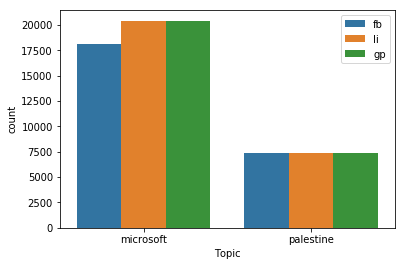

In [41]:
#count plot
sns.countplot('Topic',hue='sm',data=data)
plt.legend(loc=0)
plt.show()

Popularity based on weekday and weekend

In [42]:
final['weekday']=final['month'].apply(lambda x:x.weekday())

In [43]:
final['weekday/weekend']=np.where(final['weekday']<=5,'weekday','weekend')

In [44]:
final.tail()

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,S_Source,month,weekday,weekday/weekend
93229,61849.0,Read Microsoft's Cringeworthy Millennial-Bait ...,For any corporate recruiter thinking about add...,Fortune,microsoft,2016-07-07 15:06:11,0.051031,0.178885,-1.0,0.0,6.0,Dailies/Journals,2016-07-01,4,weekday
93233,104799.0,Tournoi de foot solidaire pour la Palestine,Dans le cadre de la campagne annuelle de solid...,L'Humanité,palestine,2016-07-07 15:20:27,-0.047246,-0.106600,4.0,0.0,0.0,Dailies/Journals,2016-07-01,4,weekday
93236,104793.0,Palestinian Government Uses Foreign Aid To Pay...,The Palestinian government spends nearly $140 ...,Daily Caller,palestine,2016-07-07 15:38:26,0.291667,-0.139754,5.0,1.0,0.0,Dailies/Journals,2016-07-01,4,weekday
93237,104794.0,Palestine Youth Orchestra prepares for first U...,Palestine Youth Orchestra prepares for first U...,Ahram Online,palestine,2016-07-07 15:59:22,0.121534,0.092313,0.0,0.0,0.0,Dailies/Journals,2016-07-01,4,weekday
93238,61870.0,Sausalito businesswoman wins $10000 in Microso...,"Goldstein, the proprietor of the TG Travel Gro...",East Bay Times,microsoft,2016-07-07 16:16:11,0.000000,0.054554,-1.0,1.0,0.0,Dailies/Journals,2016-07-01,4,weekday


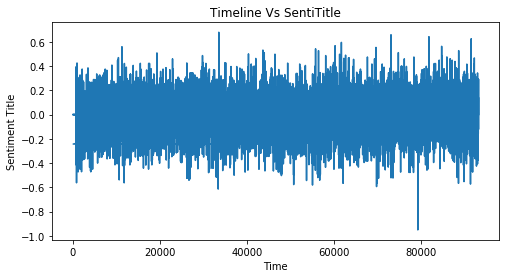

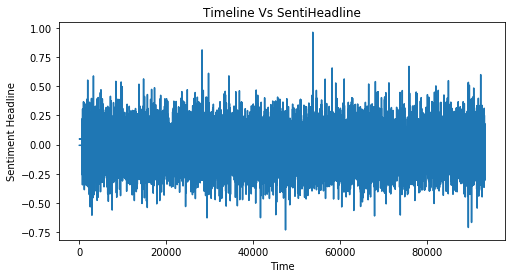

In [45]:
#Sentiment analysis of title and headlines 
sentiment_title = final.SentimentTitle
sentiment_headline = final.SentimentHeadline

plt.figure(figsize=(8, 4))
plt.plot(sentiment_title)
plt.xlabel('Time')
plt.ylabel('Sentiment Title')
plt.title('Timeline Vs SentiTitle')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(sentiment_headline)
plt.xlabel('Time')
plt.ylabel('Sentiment Headline')
plt.title('Timeline Vs SentiHeadline')
plt.show()

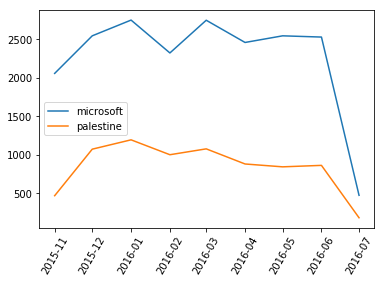

In [46]:
#Count of obama and economy per month
print('\n')
for i in final.Topic.unique():
    plt.plot(final[final['Topic']==i].groupby(['month']).IDLink.count(),label=i)
plt.xticks(rotation=60)
plt.legend()
plt.show()

In [47]:
final[final['Topic']=='microsoft'].groupby(['month']).month.value_counts()

month       month     
2015-11-01  2015-11-01    2056
2015-12-01  2015-12-01    2543
2016-01-01  2016-01-01    2747
2016-02-01  2016-02-01    2321
2016-03-01  2016-03-01    2745
2016-04-01  2016-04-01    2457
2016-05-01  2016-05-01    2543
2016-06-01  2016-06-01    2527
2016-07-01  2016-07-01     476
Name: month, dtype: int64

In [48]:
final[final['Topic']=='palestine'].groupby(['month']).month.value_counts()

month       month     
2015-11-01  2015-11-01     471
2015-12-01  2015-12-01    1074
2016-01-01  2016-01-01    1195
2016-02-01  2016-02-01    1002
2016-03-01  2016-03-01    1078
2016-04-01  2016-04-01     882
2016-05-01  2016-05-01     845
2016-06-01  2016-06-01     864
2016-07-01  2016-07-01     185
Name: month, dtype: int64

Sentiment Title



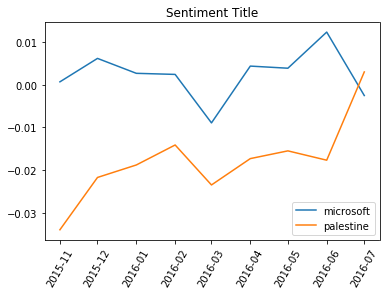

Sentiment HeadLine



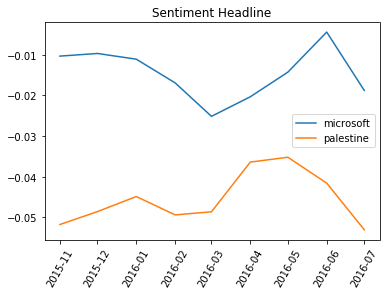

In [49]:
# avarage sentiments of economy and obama
print('Sentiment Title\n')
for i in final.Topic.unique():
    plt.plot(final[final['Topic']==i].groupby(['month']).SentimentTitle.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Sentiment Title')
plt.legend()
plt.show()

print('Sentiment HeadLine\n')
for i in final.Topic.unique():
    plt.plot(final[final['Topic']==i].groupby(['month']).SentimentHeadline.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Sentiment Headline')
plt.legend()
plt.show()

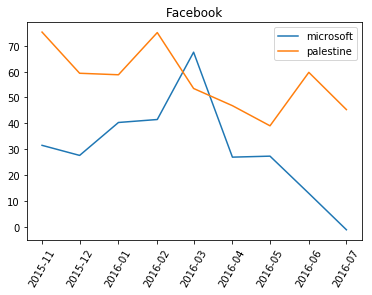

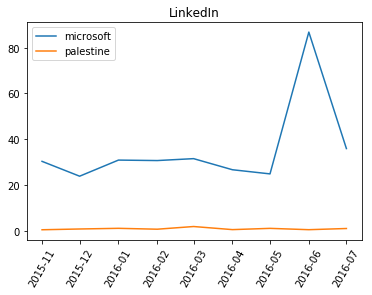

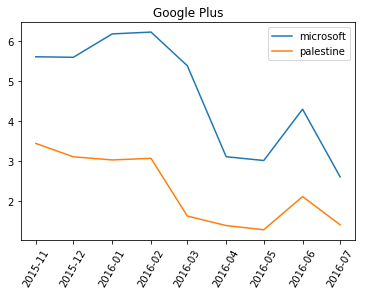

In [50]:
# Plot 1- Average unique topics in facebook for each month

for i in data.Topic.unique():
    plt.plot(data[data['Topic']==i].groupby(['month']).Facebook.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Facebook')
plt.legend()
plt.show()

# Plot 2- Average unique topics in LinkedIn for each month


for i in data.Topic.unique():
    plt.plot(data[data['Topic']==i].groupby(['month']).LinkedIn.mean(),label=i)
plt.xticks(rotation=60)
plt.title('LinkedIn')
plt.legend()
plt.show()

#Plot 3- Average unique topics in GooglePlus for each month

for i in data.Topic.unique():
    plt.plot(data[data['Topic']==i].groupby(['month']).GooglePlus.mean(),label=i)
plt.xticks(rotation=60)
plt.title('Google Plus')
plt.legend()
plt.show()

In [51]:
facebook = [fb_micro,fb_pal]   #concating all the items according to the social platform
facebook = pd.concat(facebook)

linkedin = [li_micro,li_pal]
linkedin = pd.concat(linkedin)

gplus = [gp_micro,gp_pal]
googleplus = pd.concat(gplus)

Facebook:




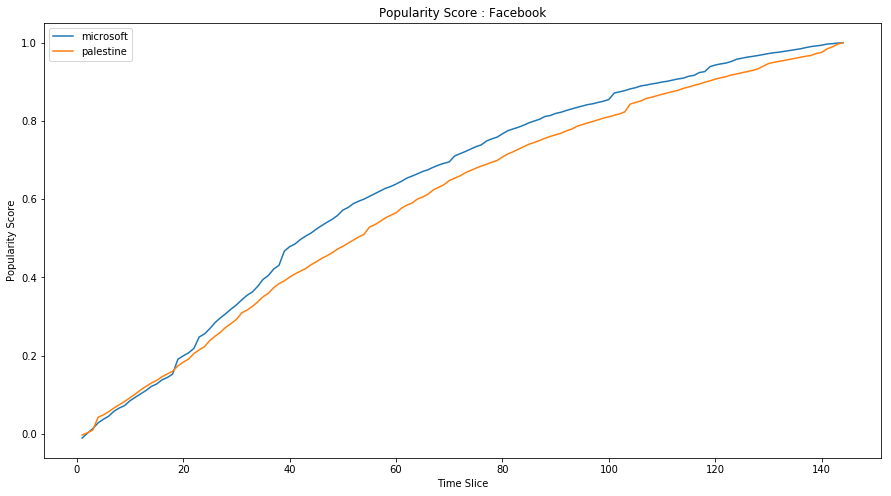

LinkedIN:




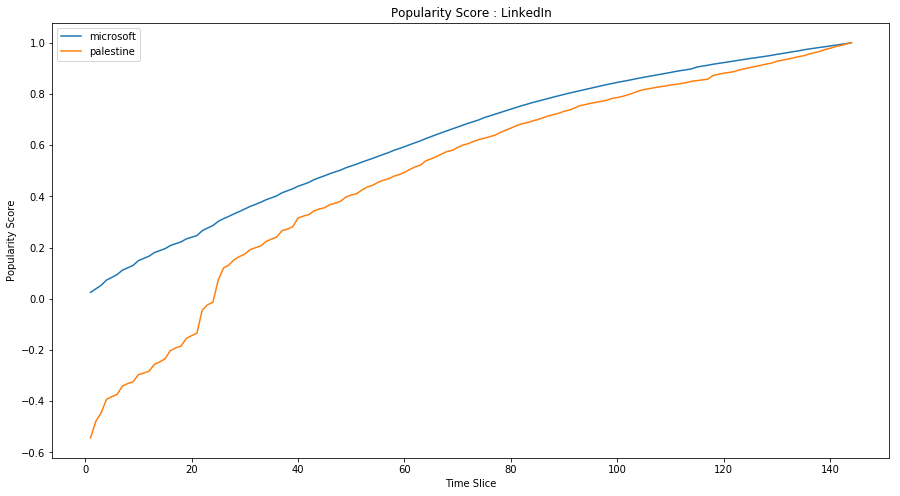

Google Plus:




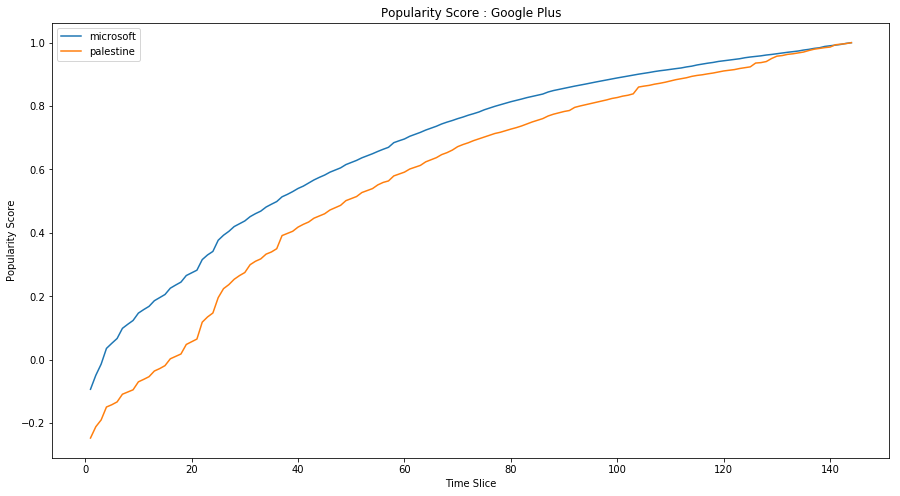

In [65]:
#plot-1 The grap explains the time span the news took to enter social media platform
print('Facebook:\n\n')

columns = [i for i in facebook if i not in ('IDLink','sm_title')]
l1 = list()
l2 = list()
l3 = range(1,145)
for i in columns:
    t_ob=np.mean(fb_micro[i])
    t_ec=np.mean(fb_pal[i])
    l1.append(t_ob/np.mean(fb_micro['TS144']))
    l2.append(t_ec/np.mean(fb_pal['TS144']))
plt.figure(figsize=(15,8))
plt.plot(l3,l1,label='microsoft')
plt.plot(l3,l2,label='palestine')
plt.xlabel('Time Slice')
plt.ylabel('Popularity Score')
plt.title('Popularity Score : Facebook')
plt.legend()
plt.show()

print('LinkedIN:\n\n')

columns = [i for i in linkedin if i not in ('IDLink','sm_title')]
l1 = list()
l2 = list()
l3 = range(1,145)
for i in columns:
    t_ob=np.mean(li_micro[i])
    t_ec=np.mean(li_pal[i])
    l1.append(t_ob/np.mean(li_micro['TS144']))
    l2.append(t_ec/np.mean(li_pal['TS144']))
plt.figure(figsize=(15,8))
plt.plot(l3,l1,label='microsoft')
plt.xlabel('Time Slice')
plt.ylabel('Popularity Score')
plt.plot(l3,l2,label='palestine')
plt.title('Popularity Score : LinkedIn')
plt.legend()
plt.show()

print('Google Plus:\n\n')

columns = [i for i in googleplus if i not in ('IDLink','sm_title')]
l1 = list()
l2 = list()
l3 = range(1,145)
for i in columns:
    t_ob=np.mean(gp_micro[i])
    t_ec=np.mean(gp_pal[i])
    l1.append(t_ob/np.mean(gp_micro['TS144']))
    l2.append(t_ec/np.mean(gp_pal['TS144']))
plt.figure(figsize=(15,8))
plt.plot(l3,l1,label='microsoft')
plt.plot(l3,l2,label='palestine')
plt.xlabel('Time Slice')
plt.ylabel('Popularity Score')
plt.title('Popularity Score : Google Plus')
plt.legend()
plt.show()

MICROSOFT :
FB :


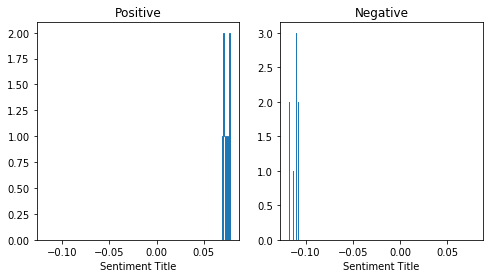

LI :


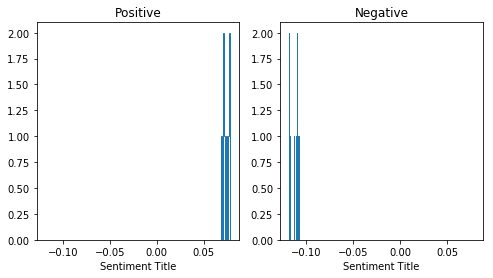

GP :


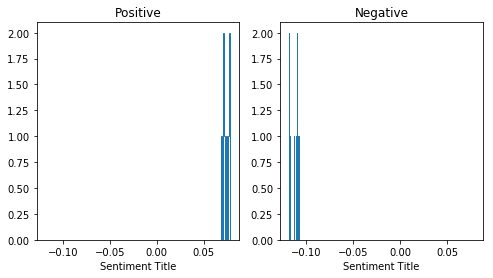

PALESTINE :
FB :


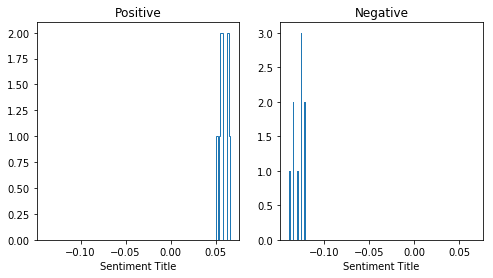

LI :


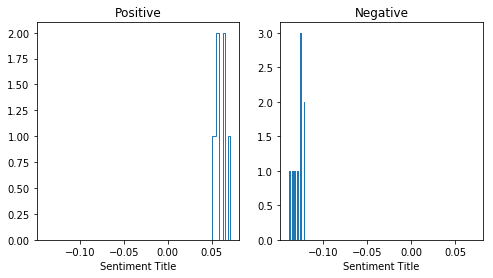

GP :


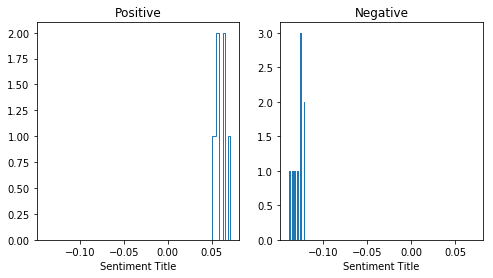

In [60]:
#The plots demonstrates the positive and negative score of Economy and Obama in 3 different social media platform

for i in data.Topic.unique():
    temp=data[data['Topic']==i]
    
    print(i.upper(),':')
    for j in temp.sm.unique():
        print(j.upper(),':')
        t = temp[temp['sm']==j]
        temp_pos=t[t['SentimentTitle']>=0]
        temp_neg=t[t['SentimentTitle']<0]
        
        f , ax_arr = plt.subplots(1 , 2 , figsize=(8,4),sharex=True)
        
        ax_arr[0].hist(temp_pos.groupby('month')['SentimentTitle'].mean(),align='mid',histtype='step')
        ax_arr[0].set_title('Positive')
        ax_arr[0].set_xlabel('Frequency')
        ax_arr[0].set_xlabel('Sentiment Title')
        
    
        ax_arr[1].hist(temp_neg.groupby('month')['SentimentTitle'].mean())
        ax_arr[1].set_title('Negative')
        ax_arr[1].set_xlabel('Frequency')
        ax_arr[1].set_xlabel('Sentiment Title')
        

        plt.show()

## Sentiment Score Calculation

In [61]:
final.head(1)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,S_Source,month,weekday,weekday/weekend
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.0,-0.132812,0.0,0.0,0.0,Online,2015-11-01,6,weekend


In [62]:
df = final

In [63]:
df['Positive'] = np.where(round(df['SentimentTitle'])<0,0,1)

In [64]:
sentiment = SentimentIntensityAnalyzer()
df.dropna(inplace=True)
def get_sentiment(review):
    compound = sentiment.polarity_scores(review)['compound']
    if compound<0:
        return 0
    else:
        return 1
    
df['vaderTitle']=df['Title'].apply(get_sentiment)

accuracy_score(df['Positive'],df['vaderTitle'])

0.8121989792250737

In [65]:
def get_sentiment(review):
    compound = TextBlob(review).sentiment[0]
    if compound<0:
        return 0
    else:
        return 1
    
df['textblobTitle']=df['Title'].apply(get_sentiment)
accuracy_score(df['Positive'],df['textblobTitle'])

0.9028466681043779

In [66]:
df['Positive_HL'] = np.where(round(df['SentimentHeadline'])<0,0,1)

In [67]:
df.dropna(inplace=True)
def get_sentiment(review):
    compound = sentiment.polarity_scores(review)['compound']
    if compound<0:
        return 0
    else:
        return 1
    
df['vaderHL']=df['Headline'].apply(get_sentiment)

accuracy_score(df['Positive_HL'],df['vaderHL'])

0.8005894615771691

In [68]:
def get_sentiment(review):
    compound = TextBlob(review).sentiment[0]
    if compound<0:
        return 0
    else:
        return 1
    
df['textblobHL']=df['Headline'].apply(get_sentiment)

accuracy_score(df['Positive_HL'],df['textblobHL'])

0.8293796276328086

In [69]:
df.dropna(inplace=True)
def get_sentiment(review):
    compound = sentiment.polarity_scores(review)['compound']
    return compound
    
df['vaderHL']=df['Headline'].apply(get_sentiment)
df['vaderTitle']=df['Title'].apply(get_sentiment)

In [70]:
def get_sentiment(review):
    compound = TextBlob(review).sentiment[0]
    return compound
    
df['textblobTitle']=df['Title'].apply(get_sentiment)
df['textblobHL']=df['Headline'].apply(get_sentiment)

## Topic Modelling

In [71]:
df_obama = df[df['Topic'] == 'microsoft']
df_economy = df[df['Topic'] == 'palestine']

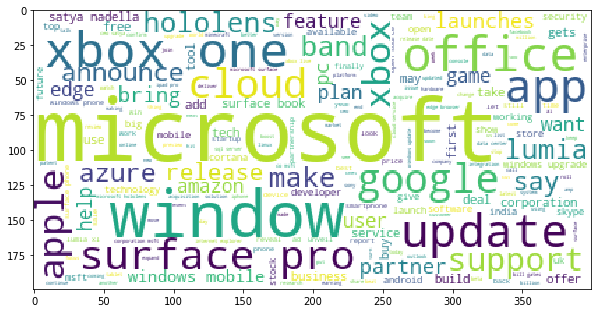

In [123]:
#Corpus

docs = df_obama.Title.str.lower().str.replace('[^a-z\' ]','')
stopwords = nltk.corpus.stopwords.words('English')
stopwords.extend(['microsoft','new'])

stemmer = nltk.stem.PorterStemmer()
def clean_sen(text):
    text=str(text)
    ws = text.split(' ')
    ws = [w.strip() for w in ws]
    ws_clean = [w for w in ws if w not in stopwords]
    return ' '.join(ws_clean)

docs_clean = docs.apply(clean_sen)

#Merging all paragraphs as a single string
text = ' '.join(para for para in docs_clean)

#Creating the word cloud
plt.figure(figsize=(10,10))
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

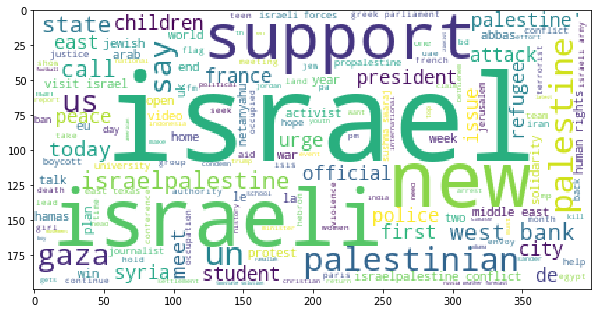

In [114]:
#Corpus

docs = df_economy.Title.str.lower().str.replace('[^a-z\' ]','')
stopwords = nltk.corpus.stopwords.words('English')
stopwords.extend(['palestine','palestinian'])

stemmer = nltk.stem.PorterStemmer()
def clean_sen(text):
    text=str(text)
    ws = text.split(' ')
    ws_clean = [w for w in ws if w not in stopwords]
    return ' '.join(ws_clean)

docs_clean = docs.apply(clean_sen)

#Merging all paragraphs as a single string
text = ' '.join(para for para in docs_clean)

#Creating the word cloud
plt.figure(figsize=(10,10))
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

In [74]:
docs_title = df['Title'].fillna('').str.lower().str.replace('[^a-z ]','')
docs_headline = df['Headline'].fillna('').str.lower().str.replace('[^a-z ]','')

In [75]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend([])

docs_title_clean = []
for doc in docs_title:
    words = doc.split(' ')
    wc = [stemmer.stem(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_title_clean.append(wc)

In [76]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend([])

docs_headline_clean = []
for doc in docs_headline:
    words = doc.split(' ')
    wc = [stemmer.stem(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_headline_clean.append(wc)

In [77]:
import gensim

dictionary_t = gensim.corpora.Dictionary(docs_title_clean)
dictionary_hl = gensim.corpora.Dictionary(docs_headline_clean)

In [78]:
docs_bow_title = []
for doc in docs_title_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_title.append(bow)

docs_bow_headline = []
for doc in docs_headline_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_headline.append(bow)

In [79]:
c_scores = []
for i in range(4,20):
    lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=i,random_state=100)
    coher_model = CoherenceModel(lda_model,corpus=docs_bow_title,coherence='u_mass')
    score = coher_model.get_coherence()
    c_scores.append(score)

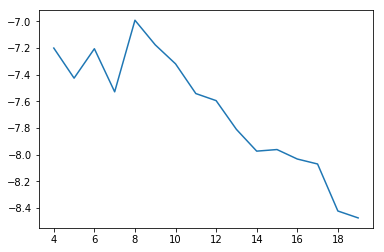

In [80]:
l1=list(range(4,20))
d=dict()
j=0
for i in l1:
    d[i]=c_scores[j]
    j=j+1
sns.lineplot(l1,c_scores)

In [81]:
lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=5,random_state=100)

In [82]:
lda_model.get_document_topics(docs_bow_title[0])

[(0, 0.017029138),
 (1, 0.016923577),
 (2, 0.016865162),
 (3, 0.016875923),
 (4, 0.9323062)]

In [83]:
topics_df = pd.DataFrame(lda_model.get_document_topics(docs_bow_title[1]),columns=['Topic','Probablity'])
topics_df.sort_values(by='Probablity').iloc[:]['Topic']

2    2
1    1
0    0
4    4
3    3
Name: Topic, dtype: int64

In [84]:
lda_model.print_topics()

[(0,
  '0.084*"microsoft" + 0.034*"palestin" + 0.022*"" + 0.014*"new" + 0.009*"xbox" + 0.007*"israel" + 0.006*"window" + 0.006*"one" + 0.005*"linkedin" + 0.005*"cloud"'),
 (1,
  '0.084*"microsoft" + 0.044*"" + 0.020*"palestin" + 0.014*"palestinian" + 0.012*"xbox" + 0.008*"new" + 0.008*"one" + 0.007*"surfac" + 0.007*"game" + 0.006*"updat"'),
 (2,
  '0.085*"" + 0.060*"microsoft" + 0.030*"palestin" + 0.012*"israel" + 0.012*"palestinian" + 0.008*"window" + 0.008*"isra" + 0.007*"xbox" + 0.007*"app" + 0.006*"kill"'),
 (3,
  '0.100*"microsoft" + 0.049*"" + 0.011*"linkedin" + 0.010*"window" + 0.010*"palestin" + 0.008*"data" + 0.007*"app" + 0.007*"palestinian" + 0.006*"updat" + 0.006*"new"'),
 (4,
  '0.119*"" + 0.110*"microsoft" + 0.020*"window" + 0.011*"new" + 0.009*"palestin" + 0.008*"surfac" + 0.006*"cloud" + 0.005*"lumia" + 0.005*"pro" + 0.005*"updat"')]

In [85]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [86]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [87]:
temp = df[df['Topic']=='microsoft']

docs_title = temp['Title'].fillna('').str.lower().str.replace('[^a-z ]','')
docs_headline = temp['Headline'].fillna('').str.lower().str.replace('[^a-z ]','')

stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['microsoft'])

docs_title_clean = []
for doc in docs_title:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_title_clean.append(wc)

In [88]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['microsoft'])

docs_headline_clean = []
for doc in docs_headline:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_headline_clean.append(wc)

In [89]:
dictionary_t = gensim.corpora.Dictionary(docs_title_clean)
dictionary_hl = gensim.corpora.Dictionary(docs_headline_clean)

docs_bow_title = []
for doc in docs_title_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_title.append(bow)

docs_bow_headline = []
for doc in docs_headline_clean:
    bow = dictionary_t.doc2bow(doc)
    docs_bow_headline.append(bow)

In [90]:
c_scores = []
for i in range(1,10 ):
    lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=i,random_state=100)
    coher_model = CoherenceModel(lda_model,corpus=docs_bow_title,coherence='u_mass')
    score = coher_model.get_coherence()
    c_scores.append(score)

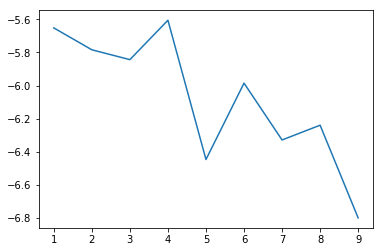

In [91]:
l1=list(range(1,10))
d=dict()
j=0
for i in l1:
    d[i]=c_scores[j]
    j=j+1
sns.lineplot(l1,c_scores)

In [92]:
lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_t,num_topics=2,random_state=100)

In [93]:
lda_model.get_document_topics(docs_bow_title[0])

[(0, 0.09440025), (1, 0.9055998)]

In [94]:
topics_df = pd.DataFrame(lda_model.get_document_topics(docs_bow_title[1]),columns=['Topic','Probablity'])
topics_df.sort_values(by='Probablity').iloc[:]['Topic']

1    1
0    0
Name: Topic, dtype: int64

In [95]:
lda_model.print_topics()

[(0,
  '0.066*"" + 0.014*"xbox" + 0.014*"surface" + 0.014*"microsofts" + 0.010*"new" + 0.010*"window" + 0.010*"one" + 0.008*"cloud" + 0.007*"linkedin" + 0.006*"apple"'),
 (1,
  '0.113*"" + 0.025*"window" + 0.023*"microsofts" + 0.012*"new" + 0.007*"update" + 0.005*"office" + 0.005*"lumia" + 0.005*"xbox" + 0.004*"get" + 0.004*"data"')]

Topic modeling for Economy

In [96]:
temp_eco = df[df['Topic']=='palestine']

docs_title = temp_eco['Title'].fillna('').str.lower().str.replace('[^a-z ]','')
docs_headline = temp_eco['Headline'].fillna('').str.lower().str.replace('[^a-z ]','')

stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['palestine'])

docs_title_clean = []
for doc in docs_title:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_title_clean.append(wc)

In [97]:
stopwords = nltk.corpus.stopwords.words('English')
stemmer = nltk.stem.PorterStemmer()
stopwords.extend(['palestine'])

docs_headline_clean = []
for doc in docs_headline:
    words = doc.split(' ')
    wc = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]
    wc = [word for word in wc if word not in stopwords]
    docs_headline_clean.append(wc)

In [98]:
dictionary_e = gensim.corpora.Dictionary(docs_title_clean)
dictionary_eco = gensim.corpora.Dictionary(docs_headline_clean)

docs_bow_title = []
for doc in docs_title_clean:
    bow = dictionary_e.doc2bow(doc)
    docs_bow_title.append(bow)

docs_bow_headline = []
for doc in docs_headline_clean:
    bow = dictionary_e.doc2bow(doc)
    docs_bow_headline.append(bow)

In [99]:
c_scores = []
for i in range(1,10 ):
    lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_e,num_topics=i,random_state=100)
    coher_model = CoherenceModel(lda_model,corpus=docs_bow_title,coherence='u_mass')
    score = coher_model.get_coherence()
    c_scores.append(score)

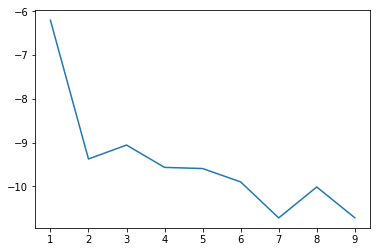

In [100]:
l1=list(range(1,10))
d=dict()
j=0
for i in l1:
    d[i]=c_scores[j]
    j=j+1
sns.lineplot(l1,c_scores)

In [101]:
lda_model = LdaMulticore(docs_bow_title,id2word=dictionary_e,num_topics=5,random_state=100)

In [102]:
lda_model.get_document_topics(docs_bow_title[0])

[(0, 0.020421412),
 (1, 0.020839745),
 (2, 0.020374501),
 (3, 0.72373676),
 (4, 0.21462756)]

In [103]:
topics_df = pd.DataFrame(lda_model.get_document_topics(docs_bow_title[1]),columns=['Topic','Probablity'])
topics_df.sort_values(by='Probablity').iloc[:]

,Topic,Probablity
2,2,0.033589
3,3,0.034080
4,4,0.034105
1,1,0.035457
0,0,0.862769


In [104]:
lda_model.print_topics()

[(0,
  '0.047*"" + 0.035*"palestinian" + 0.019*"israel" + 0.014*"israeli" + 0.006*"call" + 0.006*"say" + 0.005*"peace" + 0.005*"conflict" + 0.005*"u" + 0.005*"israelpalestine"'),
 (1,
  '0.063*"" + 0.030*"palestinian" + 0.020*"israel" + 0.012*"east" + 0.006*"peace" + 0.005*"arab" + 0.004*"support" + 0.004*"texas" + 0.004*"israeli" + 0.004*"solidarity"'),
 (2,
  '0.033*"" + 0.029*"israel" + 0.011*"israelpalestine" + 0.008*"palestinian" + 0.006*"islamic" + 0.006*"peace" + 0.005*"state" + 0.005*"west" + 0.004*"support" + 0.004*"say"'),
 (3,
  '0.088*"" + 0.023*"palestinian" + 0.018*"israel" + 0.009*"israeli" + 0.008*"israelpalestine" + 0.007*"week" + 0.007*"new" + 0.006*"today" + 0.005*"police" + 0.005*"peace"'),
 (4,
  '0.040*"palestinian" + 0.032*"" + 0.010*"israel" + 0.008*"israeli" + 0.007*"un" + 0.007*"new" + 0.006*"gaza" + 0.005*"conference" + 0.004*"israelpalestine" + 0.004*"israelipalestinian"')]

In [105]:
 df.head(2)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,...,S_Source,month,weekday,weekday/weekend,Positive,vaderTitle,textblobTitle,Positive_HL,vaderHL,textblobHL
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0.0,0.0,...,Online,2015-11-01,6,weekend,1,0.3182,0.1875,1,0.8176,0.294573
729,307.0,Microsoft scales back free online storage plans,NEW YORK — Microsoft is getting stingy with on...,The Columbian,microsoft,2015-11-08 06:54:00,0.106303,-0.207333,0.0,0.0,...,Dailies/Journals,2015-11-01,6,weekend,1,0.5106,0.2000,1,0.5719,0.131210


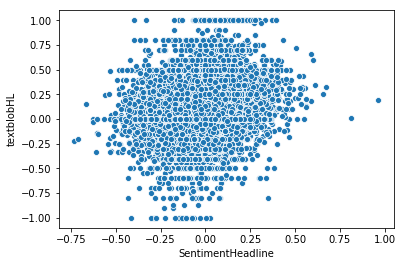

In [106]:
sns.scatterplot(df.SentimentHeadline,df.textblobHL)

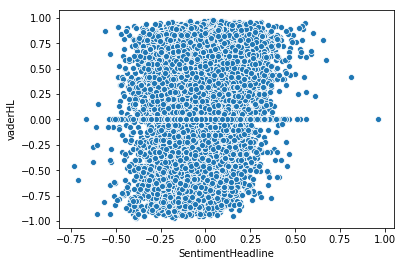

In [107]:
sns.scatterplot(df.SentimentHeadline,df.vaderHL)

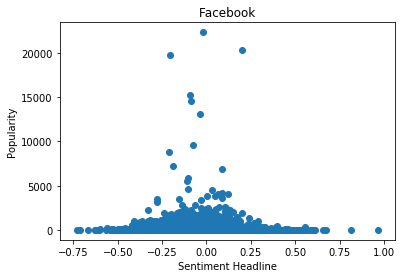

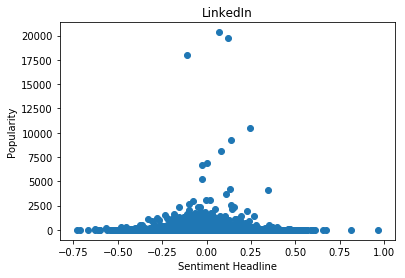

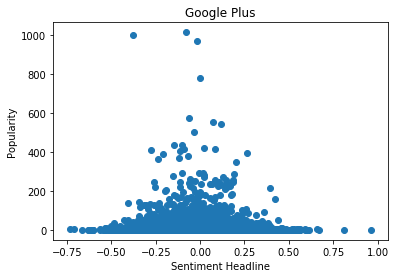

In [108]:
plt.scatter(df.SentimentHeadline,df.Facebook)
plt.title('Facebook')
plt.xlabel('Sentiment Headline')
plt.ylabel('Popularity')
plt.show()

plt.scatter(df.SentimentHeadline,df.LinkedIn)
plt.title('LinkedIn')
plt.xlabel('Sentiment Headline')
plt.ylabel('Popularity')
plt.show()

plt.scatter(df.SentimentHeadline,df.GooglePlus)
plt.title('Google Plus')
plt.xlabel('Sentiment Headline')
plt.ylabel('Popularity')
plt.show()